# Ackley Function Sensivity Analysis

## 1. Introduction

The present code evaluates the performance of the TuRBO algorithm in finding the minimum of the Ackley function while varying:

- The number of trust regions (TR)
- The batch size
- The number of initial points per TR
- The dimensionality of the function

The performance will be evaluated as follows: three of this parameters will be kept constant, while one will be varied. The optimization process will be run on the function and the minimum value found will be recorded. Then, we will compare the values obtained for each value of the parameter. The maximum number of evaluations (`max_evals`) will be by the user in the variable `max_evals_desired`.

When not varied, the parameters will be fixed at:

- `n_trust_regions` = 5
- `batch_size` = 10 
- `n_init` = 10 (20 on Turbo1)
- `dim` = 10

Each experiment is going to run for `n_times` times, then the mean will be calculated and plotted. An experiment is considered to be the run of the algorithm with determined values of it's hyperparameters.

### 1.1 About the function

### Ackley Function

The **Ackley function** is a widely used non-convex benchmark function for testing global optimization algorithms.  
It is characterized by a nearly flat outer region, with a large number of local minima, and a very steep hole at the center. This makes it particularly difficult for hill-climbing or derivative-based methods, which can easily get trapped in the surrounding local optima.



The global minimum is located at:

$$x_i = 0 \text{ for all } i$$

with function value:

$$f(x) = 0$$

### Definition

For a $d$-dimensional vector $x = (x_1, \dots, x_d)$, the Ackley function is defined as:

$$f(x) = -20 \exp \left( -0.2 \sqrt{\frac{1}{d} \sum_{i=1}^{d} x_i^2} \right) - \exp \left( \frac{1}{d} \sum_{i=1}^{d} \cos(2\pi x_i) \right) + 20 + \exp(1)$$

---

It is commonly evaluated over the domain:

$$x_i \in [-32.768, 32.768]$$

## 2. Pre-test codes

### 2.1 Imports

In [1]:
from turbo import TurboM 
from turbo import Turbo1
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt

### 2.2 Ackley Function Class

In [2]:
class Ackley:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -32.768 * np.ones(dim)
        self.ub = 32.768 * np.ones(dim)
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        a = 20
        b = 0.2
        c = 2 * np.pi
        
        sum1 = np.sum(x**2)
        term1 = -a * np.exp(-b * np.sqrt(sum1 / self.dim))
        
        sum2 = np.sum(np.cos(c * x))
        term2 = -np.exp(sum2 / self.dim)
        
        val = term1 + term2 + a + np.exp(1)
        return val

f = Ackley(10)

### 2.3 How many times each experiment will run

In [3]:
n_times = 5

### 2.4 How many evaluations will be made

In [4]:
max_evals_desired = 500

## 3. Varying `n_trust_regions`

In [5]:
n_trust_regions_list = [1, 2, 3, 4, 8, 12, 16, 22, 26]
n_trust_regions_list.sort() # guarantees that values are in crescent order

results_NTR = {NTR: [] for NTR in n_trust_regions_list}

### 3.1 One trust region (Turbo1)

In [6]:
for run in range(n_times):

    np.random.seed(run) # fix numpy seed
    torch.manual_seed(run) # fix torch seed
    
    turbo1 = Turbo1(
        f=f,  
        lb=f.lb,  
        ub=f.ub,  
        n_init=20,  
        max_evals=max_evals_desired,  
        batch_size=10,  
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50,  
        min_cuda=1024,  
        device="cpu",  
        dtype="float64",  
    )

    turbo1.optimize()

    # X = turbo1.X  # Evaluated points
    fX = turbo1.fX  # Observed values

    min_value = np.min(fX)

    results_NTR[1].append(min_value)

### 3.2 More trust regions (TurboM)

In [7]:
# To make trust_regions_list = [1] + trust_regions_list_turbom
n_trust_regions_list_turbom_interm = n_trust_regions_list.copy()
n_trust_regions_list_turbom_interm.remove(1)
n_trust_regions_list_turbom = n_trust_regions_list_turbom_interm

for NTR in n_trust_regions_list_turbom:

    for run in range(n_times):

        np.random.seed(run)
        torch.manual_seed(run)

        turbo_m = TurboM(
            f=f,  
            lb=f.lb,  
            ub=f.ub,  
            n_init=10,  
            max_evals=max_evals_desired, 
            n_trust_regions=NTR, # Varying 
            batch_size=10,  
            verbose=False,  
            use_ard=True,  
            max_cholesky_size=2000,  
            n_training_steps=50, 
            min_cuda=1024,  
            device="cpu", 
            dtype="float64",  
        )

        turbo_m.optimize()

        # X = turbo_m.X  # Evaluated points
        fX = turbo_m.fX  # Observed values
        
        min_value = np.min(fX)

        results_NTR[NTR].append(min_value)

In [8]:
# Creates dictionaries that relates mean and std to each corresponding n_trust_regions value
mean_NTR = {NTR: np.mean(results_NTR[NTR]) for NTR in n_trust_regions_list}
std_NTR  = {NTR: np.std(results_NTR[NTR])  for NTR in n_trust_regions_list}

# Puts that means and stds into lists
mean_values_NTR = [mean_NTR[NTR] for NTR in n_trust_regions_list]
std_values_NTR = [std_NTR[NTR] for NTR in n_trust_regions_list]

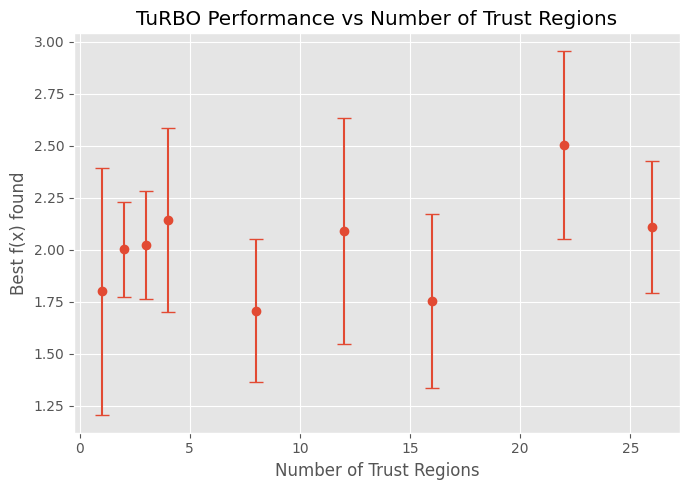

In [9]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.errorbar(
    n_trust_regions_list, 
    mean_values_NTR,
    yerr = std_values_NTR,
    fmt = "o",
    capsize = 5
    )  
plt.xlabel("Number of Trust Regions")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs Number of Trust Regions")

plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Varying the `batch_size`

In [10]:
batch_size_list = [3, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
batch_size_list.sort() # guarantees that values are in crescent order

results_BS = {BS: [] for BS in batch_size_list}

for BS in batch_size_list:

    for run in range(n_times):

        np.random.seed(run)
        torch.manual_seed(run)

        turbo_m = TurboM(
            f=f,  
            lb=f.lb,  
            ub=f.ub,  
            n_init=10,  
            max_evals=max_evals_desired, 
            n_trust_regions=5, 
            batch_size=BS,  # Varying
            verbose=False,  
            use_ard=True,  
            max_cholesky_size=2000,  
            n_training_steps=50, 
            min_cuda=1024,  
            device="cpu", 
            dtype="float64",  
        )

        turbo_m.optimize()

        # X = turbo_m.X  # Evaluated points
        fX = turbo_m.fX  # Observed values

        min_value = np.min(fX)

        results_BS[BS].append(min_value)

In [11]:
# Creates dictonaries that relates mean and std to each corresponding batch_size value
mean_BS = {BS: np.mean(results_BS[BS]) for BS in batch_size_list}
std_BS  = {BS: np.std(results_BS[BS])  for BS in batch_size_list}

# Puts that means and stds into lists
mean_values_BS = [mean_BS[BS] for BS in batch_size_list]
std_values_BS = [std_BS[BS] for BS in batch_size_list]

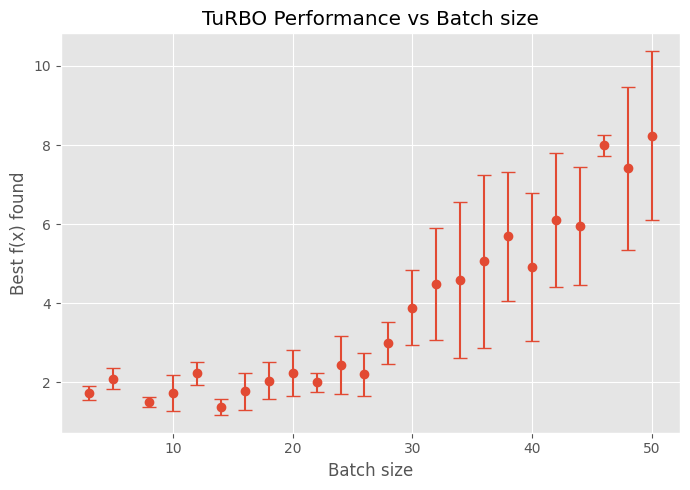

In [12]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.errorbar(
    batch_size_list,
    mean_values_BS,
    yerr=std_values_BS,
    fmt='o',        
    capsize=5       
) 
plt.xlabel("Batch size")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs Batch size")

plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Varying `n_init`

In [13]:
n_init_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

n_init_list.sort() # guarantees that values are in crescent order

results_NI = {NI: [] for NI in n_init_list}

for NI in n_init_list:

    for run in range(n_times):

        np.random.seed(run)
        torch.manual_seed(run)

        turbo_m = TurboM(
            f=f,  
            lb=f.lb,  
            ub=f.ub,  
            n_init=NI, #Varying 
            max_evals=1000, 
            n_trust_regions=5, 
            batch_size=10, 
            verbose=False,  
            use_ard=True,  
            max_cholesky_size=2000,  
            n_training_steps=50, 
            min_cuda=1024,  
            device="cpu", 
            dtype="float64",  
        )

        turbo_m.optimize()

        # X = turbo_m.X  # Evaluated points
        fX = turbo_m.fX  # Observed values

        min_value = np.min(fX)

        results_NI[NI].append(min_value)

In [14]:
# Creates dictonaries that relates mean and std to each corresponding n_init value
mean_NI = {NI: np.mean(results_NI[NI]) for NI in n_init_list}
std_NI  = {NI: np.std(results_NI[NI])  for NI in n_init_list}

# Puts that values into lists
mean_values_NI = [mean_NI[NI] for NI in n_init_list]
std_values_NI = [std_NI[NI] for NI in n_init_list]

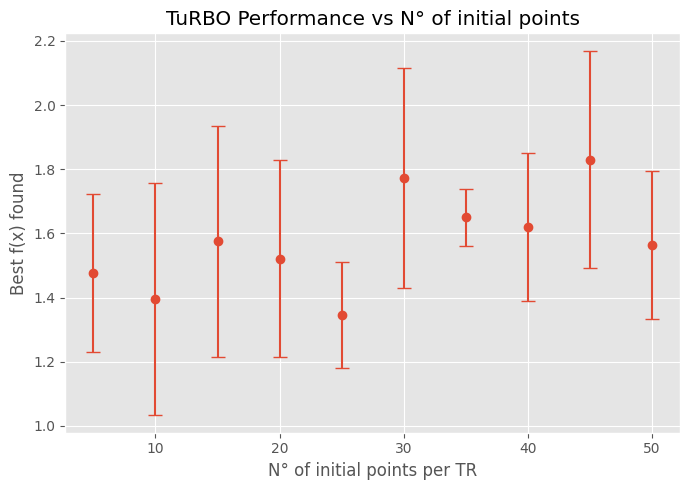

In [15]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))

plt.errorbar(
    n_init_list, 
    mean_values_NI, 
    yerr = std_values_NI, 
    fmt = 'o', 
    capsize = 5
) 

plt.xlabel("N° of initial points per TR")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs N° of initial points")

plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Varying dimensionality of the function

In [16]:
dimensionality_list = [2, 5, 8, 10, 12, 15, 17, 20, 25, 30, 35]
dimensionality_list.sort() # guarantees that values are in crescent order

results_Dim = {Dim: [] for Dim in dimensionality_list}

for Dim in dimensionality_list:

    for run in range(n_times):

        np.random.seed(run)
        torch.manual_seed(run)

        f = Ackley(Dim) # Varying

        turbo_m = TurboM(
            f=f, # Here the dimensionality varies 
            lb=f.lb,  
            ub=f.ub,  
            n_init=10,  
            max_evals=max_evals_desired, 
            n_trust_regions=5, 
            batch_size=10,
            verbose=False,  
            use_ard=True,  
            max_cholesky_size=2000,  
            n_training_steps=50, 
            min_cuda=1024,  
            device="cpu", 
            dtype="float64",  
        )

        turbo_m.optimize()

        # X = turbo_m.X  # Evaluated points
        fX = turbo_m.fX  # Observed values

        min_value = np.min(fX)

        results_Dim[Dim].append(min_value)

In [17]:
# Creates dictionaries that relates mean and std to each corresponding dimensionality value
mean_Dim = {Dim: np.mean(results_Dim[Dim]) for Dim in dimensionality_list}
std_Dim  = {Dim: np.std(results_Dim[Dim])  for Dim in dimensionality_list}

# Puts that values into lists
mean_values_Dim = [mean_Dim[Dim] for Dim in dimensionality_list]
std_values_Dim = [std_Dim[Dim] for Dim in dimensionality_list]

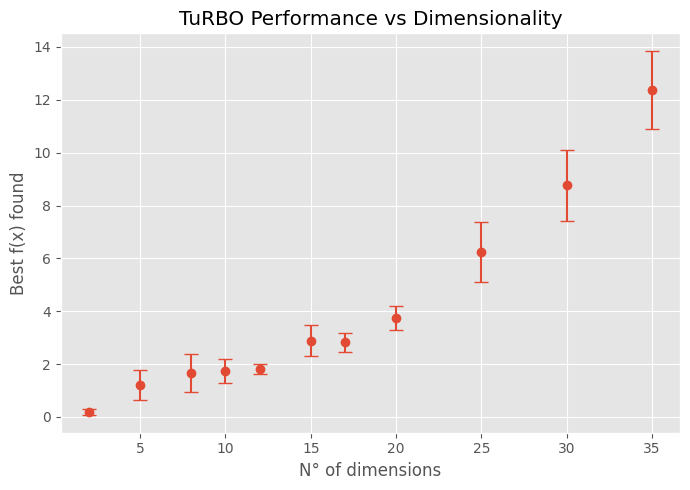

In [18]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.errorbar(
    dimensionality_list, 
    mean_values_Dim, 
    yerr = std_values_Dim, 
    fmt = "o",
    capsize = 5
)  
plt.xlabel("N° of dimensions")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs Dimensionality")

plt.grid(True)
plt.tight_layout()
plt.show()